# Hooks
**1. 什么是hook？**
hook是一个特殊的<font color=blue>函数</font>，它在autograd.Function的forward或backward method调用的前后被执行。hooks可以用来在常规module的forward/backward pass中执行任意的code，或者用来调整inputs/outputs而不用改变module本身的forward() method.\
**2. hook的使用对象？**
hook可以<font color=blue>用于**tensor或module**</font>，称为register on a tensor or nn.Module。典型使用场景：\
· <font color=green>用于tensor的时候主要用来控制从forward向backward传递信息过程中的pack/unpack information。</font>\
· <font color=green>用于module中的时候，可以用于模型可视化，debug，gradient check等。</font> \
**3. hooks的类型？**
使用hook，要先register到使用hook的位置。按照使用位置，pytorch提供了两大类hooks：forward hook和backward hook。 \
**4. hooks的作用范围？**
所有hooks都可以返回更新后的value，这些value也会被用到hooks所在pass的后续计算中。

## 1. Hooks for tensors
用于tensor的hook只有backward hook。\
**signature of hook function：**<font color=red>hook_func_name(grad) -> Tensor or None </font>\
**method for register a backward hook**：<font color=red>tensor_name.register_hook(hook_func_name)</font> \
**典型用途：**
1. <font color=green>改变tensor的梯度计算方式。</font>某个tensor x的x.grad用hook改变后，DAG上位于x前面，依赖于x的tensor的梯度也按chainrule改变。如果不用tensor hook，要等bp结束后手动改变x和每一个前序tensor的梯度。
2. <font color=green>查看intermediate tensor的grad，此时不占额外内存。</font>不用tensor hook的话就要用intermediate_tensor.remain_grad()，会占用内存。
3. <font color=green>自定义saved tensor的pack/unpack方式</font>

**backward hooks execution：** [详见Pytorch Doc:autograd mechnism]

In [1]:
import torch
import torchviz
import torch.nn as nn
import torch.nn.functional as F

### 1.1 直接改变tensor/tensor.grad value

In [2]:
## 例1：一个简单的例子
# 定义hook function
def func(grad):
    return grad * 2

In [3]:
# 1.without hook
torch.manual_seed(2)
w = torch.randn(5, requires_grad=True)
b = torch.randn(3, requires_grad=True)
x = torch.ones((3, 5))
y = x @ w + b
y.retain_grad()
loss = (y ** 2).sum()
loss.retain_grad()

loss.backward()
print(w.grad)
print(b.grad)
print(loss.grad)

tensor([-0.9064, -0.9064, -0.9064, -0.9064, -0.9064])
tensor([-1.8891,  0.5235,  0.4592])
tensor(1.)


In [4]:
# 2.with hook for loss
torch.manual_seed(2)
w = torch.randn(5, requires_grad=True)
b = torch.randn(3, requires_grad=True)
x = torch.ones((3, 5))
y = x @ w + b
y.retain_grad()
loss = (y ** 2).sum()
loss.retain_grad()

#  register hook
loss.register_hook(func)

loss.backward()

# 因为loss的gradient翻倍，导致前向传递，w和b的梯度也翻倍
print(w.grad)
print(b.grad)
print(y.grad)
print(loss.grad)

tensor([-1.8128, -1.8128, -1.8128, -1.8128, -1.8128])
tensor([-3.7783,  1.0471,  0.9184])
tensor([-3.7783,  1.0471,  0.9184])
tensor(2.)


In [5]:
# 3.with hook for w
torch.manual_seed(2)
w = torch.randn(5, requires_grad=True)
b = torch.randn(3, requires_grad=True)
x = torch.ones((3, 5))
y = x @ w + b
y.retain_grad()
loss = (y ** 2).sum()
loss.retain_grad()

#  register hook for w
w.register_hook(func)

loss.backward()

# 因为w的gradient翻倍，前向传递不影响loss,y和b
print(w.grad)
print(b.grad)
print(y.grad)
print(loss.grad)

tensor([-1.8128, -1.8128, -1.8128, -1.8128, -1.8128])
tensor([-1.8891,  0.5235,  0.4592])
tensor([-1.8891,  0.5235,  0.4592])
tensor(1.)


In [6]:
## 例2：Gradient clipping
def grad_clipper(model, val):
    for parameter in model.parameters():
        parameter.register_hook(lambda grad: grad.climp_(floor, cap))
    return model

In [7]:
## 例3：用于module中的tensor objects
#  要求：
#    1. 将linear层中bias的梯度改为0
#    2. conv layer从downstream拿到的gradient大小都不小于0

# ----------------  原模型  ----------------
class TestNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 10, 2, stride=2)
        self.relu = nn.ReLU()
        self.flatten = lambda x: x.view(-1)
        self.fc = nn.Linear(160, 5)
    
    def forward(self, x):
        x = self.relu(self.conv(x))         
        return self.fc(self.flatten(x))

torch.manual_seed(2)
x = torch.randn(1, 3, 8, 8)
net = TestNet()
out = net(x)
loss = (1 - out).mean()
loss.backward()

print(out.shape)
# bias_grad in linear layer should be -1/out.shape
print('bias_grad in linear layer:', net.fc.bias.grad)

torch.Size([5])
bias_grad in linear layer: tensor([-0.2000, -0.2000, -0.2000, -0.2000, -0.2000])


### 1.2 查看intermediate tensor或其grad信息

In [8]:
## 例2：打印intermediate output，也就是Feature value
#  定义hook
def func(grad):
    print(grad)
    return grad

torch.manual_seed(2)
w = torch.randn(5, requires_grad=True)
b = torch.randn(3, requires_grad=True)
x = torch.ones((3, 5))
y = x @ w + b
loss = (y ** 2).sum()
loss.retain_grad()

#  register hook for y，y在这里是intermediate tensor
#  如果不用hook，就要设置y.retain_grad()才能在bp结束后查看，会占用内存
y.register_hook(func)

loss.backward()

tensor([-1.8891,  0.5235,  0.4592])


#### module中给tensor加入backward hook后，Backward pass的执行顺序
1. 从root开始按照chainrule执行backward pass
2. 遇到hook后，对制定tensor的grad执行相应的ops，如果同一位置有多个hook，按他们在module中出现的顺序执行操作，而不是想chainrule那样反向操作。如下例：\
fc layer backward method     -> \
flatten layer                -> \
register for clamp           -> \
register for print shape     -> \
register for check gradient  -> \
relu layer backward method   -> \
conv layer backward method

In [9]:
# ----------------  加入hook  ----------------
class TestNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 10, 2, stride=2)
        self.relu = nn.ReLU()
        self.flatten = lambda x: x.view(-1)
        self.fc = nn.Linear(160, 5)
    
    def forward(self, x):
        x = self.relu(self.conv(x))
        
        # 设置hook：让x.grad >= 0
        # 这里处理的 x 是relu layer的output
        # relu的梯度只有0和1，所以处理relu之后的x即可
        x.register_hook(lambda grad: torch.clamp(grad, min=0))
        
        x.register_hook(lambda grad: print('size of output of relu layer:', grad.shape))
        # 再加一个hook确认有没有x.grad是负值
        # 放在这里改变的是relu运算后的x.grad
        x.register_hook(lambda grad: print('any grad < 0?', \
                                           bool((grad < 0).any())))
        x = self.flatten(x)
        # 这里处理的 x 是flatten layer的output
        x.register_hook(lambda grad: print('size of output of flatten layer:', grad.shape))

        y = self.fc(x)
        return y    
    
torch.manual_seed(2)
x = torch.randn(1, 3, 8, 8)
net = TestNet()

# 在model外部，给参数tenosr设置hook: 这里将linear层中bias的梯度改为0
# 这种方式可以在不改变module定义的条件下设置hook
for name, param in net.named_parameters():
    if 'fc' in name and 'bias' in name:
        param.register_hook(lambda grad: torch.zeros(grad.shape))

out = net(x)
loss = (1 - out).mean()
loss.backward()

# 确认bias的grad成功改成了全0
print('bias_grad in linear layer:', net.fc.bias.grad)

size of output of flatten layer: torch.Size([160])
size of output of relu layer: torch.Size([1, 10, 4, 4])
any grad < 0? False
bias_grad in linear layer: tensor([0., 0., 0., 0., 0.])


### 1.3 hooks for saved tensors：
**功能：** 改变saved tensor pack/unpack方式 \
**方法：** 
1. 定义两个hook function，一个实现pack，另一个unpack \
（1）定义pack_func(tensor): 只接受1个tensor作为argument，返回任意python类型。 \
（2）定义unpack_hook_func(output_of_pack_func)：只接受pack_func的返回值作为input argument，返回一个tensor用于后续的backward pass。该返回值的value要跟pack_func中的input的value相同，以达到原本想要从forward向backward传递信息的目的。
（3）即使x = unpack(pack(x)),但pack会将x打包成另一个object，unpack输出的x同样也是新的tensor，如果pack(x)=x，那么他们虽然是三个不同的tensor，但share memory；如果pack(x)不等于x，则x和unpack输出的xshare memory。
2. register 上述pack/unpack hooks 

**基本原则：** 
1. uppack_func(pack_func(tensor)) = tensor
2. pack_func的input不能做in-place modify
3. pack_func(tensor)的output可以是tenosr或者任意python type object 
4. pack_func和unpack_func单独作用于每个saved tensor

**执行过程：** 
1. 每次forward pass执行过程中，pack func在对应operation存储信息的时候被调用，其output会代替原本module中定义的pack func输出的output tensor而被存储。
2. 在backward pass中按照chainrule执行到对应operation的backward method的之前，unpack func会被调用，它用pack func的output作为唯一的input来计算一个new tensor。这个new tensor会作为backward method的input之一而被使用。

**典型应用场景：** <font color=blue>将forward pass中要保存的tensor存到cpu或者disk上，节省GPU memory</font>

packing: tensor([1., 1., 1., 1., 1.], requires_grad=True)
packing: tensor([2., 2., 2., 2., 2.], grad_fn=<MulBackward0>)


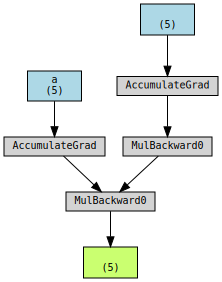

In [10]:
## 例1：saved_tensor_hooks工作过程
#  定义hook func
def pack(x):
    print('packing:', x)
    return x
def unpack(x):
    print('unpacking:', x)
    return x

a = torch.ones(5, requires_grad=True)
b = torch.ones(5, requires_grad=True) * 2

# register pack/unpack hooks
with torch.autograd.graph.saved_tensors_hooks(pack, unpack):
    y = a * b

# 从图上可以看到：
# 1.第1个packing的tensor是a
# 2.第2个packing的tensor是b，但b不是leaf，它是torch.ones(...)*2的output
torchviz.make_dot(y, params={'a':a, 'b':b})

In [11]:
y.sum().backward()

unpacking: tensor([1., 1., 1., 1., 1.], requires_grad=True)
unpacking: tensor([2., 2., 2., 2., 2.], grad_fn=<MulBackward0>)


In [12]:
## 例2.1：自定义pack和unpack规则：改变tensor大小后恢复
#  pack/unpack func满足“unpack(pack(x)) = x”的规则即可

# ---> 例2.1和例2.2没有实际意义，只是展示pack和unpack的自定义能力

def pack(x):
    print('packing:', x * 4)
    return x * 4
def unpack(x):
    print('unpacking:', x / 4)
    return x / 4
# pack/unpack func满足“unpack(pack(x)) = x”的规则

torch.manual_seed(3)
x = torch.randn(3, requires_grad=True)
print('x =', x)
with torch.autograd.graph.saved_tensors_hooks(pack, unpack):
    y = x ** 2
    
y.sum().backward()
assert(x.grad.equal(x * 2))

x = tensor([0.8033, 0.1748, 0.0890], requires_grad=True)
packing: tensor([3.2131, 0.6993, 0.3559])
unpacking: tensor([0.8033, 0.1748, 0.0890])


In [13]:
## 例2.2：自定义pack和unpack规则：保存index of a list

storage = []

def pack(x):
    storage.append(x)
    return len(storage) - 1

def unpack(ind):
    return storage[ind]

torch.manual_seed(3)
x = torch.randn(3, requires_grad=True)
with torch.autograd.graph.saved_tensors_hooks(pack, unpack):
    y = x ** 2
    
y.sum().backward()
assert(x.grad.equal(x * 2))

#### 用pack/unpack将tensor存到GPU之外的地方
1. 这是GPU memory和time的trade off。官方样例中，用A100GPU测试，把ResNet152(batch size=256)存到cpu上，可以将gpu内存使用量从48G降低到5G,但是耗时增加6倍
2. 一种折中是只把部分layer的tensor传到cpu或者其他位置。方法是，define a special nn.Module，用来wraps module and save its tensors to cpu

In [14]:
## 例3：saving tensor to cpu

#  1.人工手写
def pack(x):
    return (x.device, x.cpu())

def unpack(package):
    device, x = package
    return x.to(device)

torch.manual_seed(3)
x = torch.randn(3, requires_grad=True)
with torch.autograd.graph.saved_tensors_hooks(pack, unpack):
    y = x ** 2
    
y.sum().backward()
# assert(x.grad.equal(x * 2))
torch.allclose(x.grad, (2 * x))  # x.grad与2x值的差异在默认区间内

True

In [15]:
#  2.pytorch已经实现了上述功能

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.w = nn.Parameter(torch.randn(5))
    
    def forward(self, x):
        with torch.autograd.graph.save_on_cpu(pin_memory=True):
            return self.w * x

x = torch.randn(5)
model = Model()
loss = model(x).sum()
loss.backward()

In [16]:
#  3.module wrapper

class SaveToCpu(nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module
    
    def forward(self, *args, **kwargs):
        with torch.autograd.graph.save_on_cpu(pin_memory=True):
            return self.module(*args, **kwargs)
        
model = nn.Sequential(
    nn.Linear(10, 100), 
    nn.ReLU(), 
    SaveToCpu(nn.Linear(100, 100)), 
    nn.ReLU(), 
    nn.Linear(100, 10),
)

x = torch.randn(10)
loss = model(x).sum()
loss.backward()

In [17]:
## 例4：saving tensor to disk

## 错误的方式

import uuid
import os
import tempfile
tmp_dir_obj = tempfile.TemporaryDirectory()
tmp_dir = tmp_dir_obj.name

def pack_hook(tensor):
    name = os.path.join(tmp_dir, str(uuid.uuid4()))
    torch.save(tensor, name)
    return name

def unpack_hook(name):
    tensor = torch.load(name)
    os.remove(name)  # 如果这里remove，那么unpack就不能被call第二次
    return tensor

x = torch.ones(5, requires_grad=True)
with torch.autograd.graph.saved_tensors_hooks(pack_hook, unpack_hook):
    y = x.pow(2)
print(y.grad_fn._saved_self)      # 每执行一次就会unpack一次
try:
    print(y.grad_fn._saved_self)  # 第二次会失败
    print("Double access succeeded!")
except:
    print("Double access failed!")

tensor([1., 1., 1., 1., 1.], requires_grad=True)
Double access failed!


In [18]:
## 正确的方式：利用pytorch自动释放saved data的机制
#  pytorch自动释放不再需要的object，即这里的SelfDeletingTempFile object

class SelfDeletingTempFile():
    def __init__(self):
        self.name = os.path.join(tmp_dir, str(uuid.uuid4()))

    def __del__(self):
        os.remove(self.name)

def pack_hook(tensor):
    temp_file = SelfDeletingTempFile()
    torch.save(tensor, temp_file.name)
    return temp_file

def unpack_hook(temp_file):
    return torch.load(temp_file.name)

In [19]:
# Only save on disk tensors that have size >= 1000
SAVE_ON_DISK_THRESHOLD = 1000

def pack_hook(x):
    if x.numel() < SAVE_ON_DISK_THRESHOLD:
        return x
    temp_file = SelfDeletingTempFile()
    torch.save(tensor, temp_file.name)
    return temp_file

def unpack_hook(tensor_or_sctf):
    if isinstance(tensor_or_sctf, torch.Tensor):
        return tensor_or_sctf
    return torch.load(tensor_or_sctf.name)

class SaveToDisk(nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, *args, **kwargs):
        with torch.autograd.graph.saved_tensors_hooks(pack_hook, unpack_hook):
            return self.module(*args, **kwargs)

net = nn.DataParallel(SaveToDisk(Model()))

## 2. Hooks for nn.Module objects
用于nn.Module的hook有forward和backward hook。\
**signature of hook function：** 
1. for backward hook: <font color=red>hook_func_name(module, grad_input, grad_output) -> Tensor or None </font>
2. for foreward hook: <font color=red>hook_func_name(module, input, output) -> None </font> 

### 2.1 register forward hooks
forward hook在forward pass中被调用，具体又有两种执行位置，**pre_hook**在forward method之前执行；**hook**在forward method执行完之后执行。\
下面1和2只对当前hook所reigster上的module有效。3和4是global hook，也就是installed for all modules。
1. <font color=green>**register_forward_pre_hook(hook_func_name)**</font>
2. <font color=green>**register_forward_hook(hook_func_name)**</font>
3. <font color=green>**register_module_forward_pre_hook(hook_func_name)**</font>
4. <font color=green>**register_module_forward_hook(hook_func_name)**</font>：

### 2.2 register backward hooks
backward hook只有一种，在backward method执行完后执行。下面1和2只对当前hook所reigster上的module有效。3和4是global hook，也就是installed for all modules。
1. <font color=green>**register_full_backward_pre_hook(hook_func_name)**</font>
2. <font color=green>**register_full_backward_hook(hook_func_name)**</font>：这个是原register_backward_hook()
3. <font color=green>**register_module_full_backward_hook(hook_func_name)**</font>
4. <font color=green>**register_module_full_backward_pre_hook(hook_func_name)**</font>

In [20]:
### 例1：定义不同的hooks，看他们的工作方式

##  新建module和input
m = nn.Linear(3, 3)
torch.manual_seed(1)
x = torch.randn(2, 3, requires_grad=True)

In [21]:
## 定义foreward hook function
#  1.用于在forward pass前，检查或者调整inputs
def forward_pre_hook(m, inputs):  # 注，inputs都是wrapped成tuple类型的
    input = inputs[0]
    return input + 1.

#  2.用于在forward pass后，检查inputs/outputs或者调整outputs
def forward_hook(m, inputs, output):# inputs都wrapped成tuple，output按原类型传
    # 按ResNet的方式计算residual
    return output + inputs[0]

## register forward hooks：
#  Run input through module before and after adding hooks.
print('register前：\n{}\n'.format(m(x)))

# input调整后会产生不同的output：
forward_pre_hook_handle = m.register_forward_pre_hook(forward_pre_hook)
print('register pre hook后，output：\n{}\n'.format(m(x)))

# 调整后的output：
forward_hook_handle = m.register_forward_hook(forward_hook)
print('register两个forward hook后，output: \n{}\n'.format(m(x)))

# 去掉hooks之后，output与adding hooks之前的值一致
forward_pre_hook_handle.remove()
forward_hook_handle.remove()
print('去掉hooks: \n{}'.format(m(x)))

register前：
tensor([[-0.1644,  0.2539, -0.0903],
        [-0.5065,  0.0724, -0.1563]], grad_fn=<AddmmBackward0>)

register pre hook后，output：
tensor([[ 0.3663,  1.1868, -0.1191],
        [ 0.0242,  1.0053, -0.1852]], grad_fn=<AddmmBackward0>)

register两个forward hook后，output: 
tensor([[2.0277, 2.4538, 0.9425],
        [1.6455, 1.5534, 0.6487]], grad_fn=<AddBackward0>)

去掉hooks: 
tensor([[-0.1644,  0.2539, -0.0903],
        [-0.5065,  0.0724, -0.1563]], grad_fn=<AddmmBackward0>)


In [22]:
## 定义backward hook function
#  功能：检查grad_inputs/grad_outputs或者调整剩余bp流程中用的grad_inputs
def backward_hook(m, grad_inputs, grad_outputs): # 注，grad_inputs/grad_outputs都wrapped成tuple
    new_grad_inputs = [torch.ones_like(gi) * 42. for gi in grad_inputs]
    return new_grad_inputs

## register backward hooks:
m(x).sum().backward()
print('register前：\n{}\n'.format(x.grad))

# Clear gradients before running backward pass again.
m.zero_grad()
x.grad.zero_()

m.register_full_backward_hook(backward_hook)
m(x).sum().backward()
print('register后：\n{}\n'.format(x.grad))

register前：
tensor([[0.4999, 0.7264, 0.2085],
        [0.4999, 0.7264, 0.2085]])

register后：
tensor([[42., 42., 42.],
        [42., 42., 42.]])



In [23]:
## 例2：用forward_hook查看module中activation value的例子

class Net(nn.Module):
    def __init__(self):
        super().__init__() 
        self.conv = nn.Conv2d(3,8,2)
        self.pool = nn.AdaptiveAvgPool2d((4,4))
        self.fc = nn.Linear(8*4*4 , 1)
    def forward(self, x):
          x = F.relu(self.conv(x))
          x = self.pool(x)
          x = x.view(x.shape[0] , -1)
          x = self.fc(x)
          return x

# 定义hook，用来提取activation的结果，也就是feature
features = {} 
def hook_func(model, input ,output):
    features['feature'] = output.detach()

In [24]:
net = Net()
# 在pooling layer上register hook
net.pool.register_forward_hook(hook_func)

x= torch.randn(1,3,10,10)
output = net(x)
print(features['feature'].shape)

torch.Size([1, 8, 4, 4])


### 2.3 典型应用场景和应用方式
#### 场景1. 在模型训练过程中打印所需信息
**1. 方法：** 给module加wrapper，在wrapper module上加hooks\
**2. 优点：** \
（1）方便debug，避免手动增加和删除print的麻烦 \
（2）不仅可以在自定义module，还可以在pytorch自带的module和第三方module上使用

In [25]:
## 场景1：在ResNet18上用hooks来打印model信息

#  给model加一个wrapper class
class VerboseNet(nn.Module):
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = model
        
        # register a hook for each layer
        for name, layer in self.model.named_children():
            # 虽然所有nn.Mudule的实例都继承了__name__属性，但有的module可能没赋值
            # 这一步可以明确让layer都有对应的name
            layer.__name__ = name
            layer.register_forward_hook(
                lambda layer, _, output: print(f"new --->: {layer.__name__}: {output.shape}")
            )
    def forward(self, x: torch.Tensor):
        return self.model(x)

In [26]:
from torchvision.models import resnet18, ResNet18_Weights

verbose_resnet = VerboseNet(resnet18(weights=ResNet18_Weights.DEFAULT))
dummy_input = torch.ones(10, 3, 28, 28)

# 这里用了assignment是为了不让jupyter打印函数的output
_ = verbose_resnet(dummy_input)

new --->: conv1: torch.Size([10, 64, 14, 14])
new --->: bn1: torch.Size([10, 64, 14, 14])
new --->: relu: torch.Size([10, 64, 14, 14])
new --->: maxpool: torch.Size([10, 64, 7, 7])
new --->: layer1: torch.Size([10, 64, 7, 7])
new --->: layer2: torch.Size([10, 128, 4, 4])
new --->: layer3: torch.Size([10, 256, 2, 2])
new --->: layer4: torch.Size([10, 512, 1, 1])
new --->: avgpool: torch.Size([10, 512, 1, 1])
new --->: fc: torch.Size([10, 1000])


#### 场景2. Feature extraction
**1. 方法：** 给module加wrapper，在wrapper module上加hooks\
**2. 优点：** 在一个预训练好的模型上做transfer learning时，可能想查看该模型摸些layers上得到的feature。hook可以在不改变模型本身的条件下实现这一需求

In [27]:
## 场景2：Feature extraction

class FeatureExt(nn.Module):
    def __init__(self, model, layers):
        super().__init__()
        self.model = model
        self.layers = layers
        self._features = {layer: torch.empty(0) for layer in layers}
        
        for layer_i in layers:
            # 把named_modules的sub-module list构造成dict，用layer_i索引
            # [说明见下一个cell]
            layer = dict([*self.model.named_modules()])[layer_i]
            
            # layer_i索引出来对应layer后，给该layer加上hook:
            layer.register_forward_hook(self.save_outputs_hook(layer_i))
         
    # 定义hook function：
    def save_outputs_hook(self, layer_i):
        def fn(_, __, output):  # 下划线长度不同，因为arguments name不能相同
            # 将该layer的output提取出来，存入feature dict
            self._features[layer_i] = output
        return fn
        
    def forward(self, x):
        _ = self.model(x)
        return self._features  # 返回dict存放了指定layers的activation output

In [28]:
res18 = resnet18(weights=ResNet18_Weights.DEFAULT)
## 对resnet.named_modules的说明：
#  1. resnet18.named_modules是一个generator
#     每次yield返回的是tuple，形如('layer_name', module)
#  2. 加'*'来把generator解包成单独的tuples：*res18.named_modules()
#  3. 将dict()用到list of tuples上，可以转换成key-value pair，便于用key索引
#     这里要先将解包后的tuples打包到一个list里面，所以是用 dict([])

#  ----- 打印sample layers 来查看网络的结构  -----
# print([*res18.named_modules()][0]) # nest结构的顶层，描绘整个结构
# print('-' * 40)
# print([*res18.named_modules()][5]) # nest结构的第2层，'layer1'
# print('-' * 40)
# print([*res18.named_modules()][6]) # nest结构的第3层，'layer1'的sub-module
# print('-' * 40)
# print([*res18.named_modules()][7]) # nest结构的第4层，...

In [29]:
res18_feats = FeatureExt(res18, layers=['layer4', 'avgpool'])

fests = res18_feats(dummy_input)
for name, output in fests.items():
    print(name, '->', output.shape)

layer4 -> torch.Size([10, 512, 1, 1])
avgpool -> torch.Size([10, 512, 1, 1])
